In [1]:
import rasterio as rio
from rasterio import warp
import numpy as np
import matplotlib.pyplot as plt

from rasterio.windows import Window
from rasterio.transform import Affine

from shapely.geometry import box

## Loading Sentinel 2 data

### naming conventions:
explaining the file naming:
**T32UMF_20170619T103021_SCL_20m.jp2**
- T32UMF -> unique tile identifactor
- 20170619T103021 -> date of capturing
- SCL -> type: either SCL (classification) or TCI (RGB)
- 20m -> spatial resolution

The given files in /rgb and /classifcation should match in tile and date of capturing.


assuming the *satellite.zip* file is **unzipped** inside this folder: ./satellite/rgb and ./satellite/classifications we can load them:

In [2]:
rgb = rio.open("satellite/rgb/T32UMF_20170619T103021_TCI_10m.jp2")
scl = rio.open(
    "satellite/classifications/T32UMF_20170619T103021_SCL_20m.jp2"
)

### read as array and plot

In [3]:
# read rgb as array
rgb_arr = []
for i in range(rgb.count): # iterate over bands/channel
    # you can only read one band/channel at a time
    rgb_arr.append(rgb.read(i + 1))
rgb_arr = np.stack(rgb_arr, 0) # combine to single array

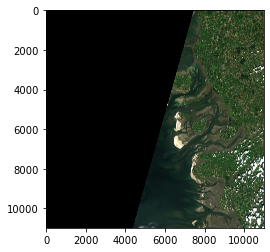

In [4]:
plt.imshow(np.moveaxis(rgb_arr, 0, -1))

In [5]:
rgb_arr.shape

(3, 10980, 10980)

In [10]:
# read scl as array
scl_arr = []
for i in range(scl.count): # iterate over bands/channel
    # you can only read one band/channel at a time
    scl_arr.append(scl.read(i + 1))
scl_arr = np.stack(scl_arr, 0) # combine to single array

The key to the scl file and what to do with the rgb data (by masking)

| Label | Classification | Action |
| -- | -- | -- |
|0| no data | exclude |
|1| saturated or defective | exclude |
|2| dark_area_pixels | |
|3| cloud_shadows | exclude |
|4| vegetation | |
|5| not vegetated | |
|6| water | not more than 20-30% per sample |
|7| unclassified | |
|8| cloud medium probability | exclude |
|9| cloud medium probability | exclude |
|10| thin cirrus | exclude |
|11| snow | exclude |

from https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

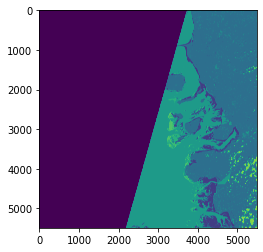

In [13]:
plt.imshow(scl_arr[0]) # note the different x/y axis

In [28]:
scl_arr

array([[[0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [0, 0, 0, ..., 9, 9, 9],
        [0, 0, 0, ..., 9, 9, 9],
        [0, 0, 0, ..., 9, 9, 9]]], dtype=uint8)

## align both images

In [14]:
# align classfication data to rgb data because of different spatial resolution
def align(src, dst, src_arr, dst_arr):
    src_new = np.repeat(np.zeros_like(dst_arr[[0]]), src.count, 0)
    warp.reproject(
        src_arr, src_new, 
        src_crs=src.crs, dst_crs=dst.crs,
        src_transform=src.transform, dst_transform=dst.transform,
        dst_resolution=dst.res,
        resampling=warp.Resampling.nearest
    )
    return src_new

In [15]:
scl_align = align(scl, rgb, scl_arr, rgb_arr)

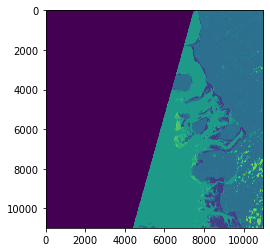

In [16]:
plt.imshow(scl_align[0]) # note that the resolution matches

In [17]:
# shapes are the same now
scl_align[0].shape == rgb_arr[0].shape

True

In [18]:
# we wont need to read the bands anymore
scl.close()
rgb.close()

## Load High Quality Landcover Classification

Here are the classes represented in the data. Disregard cloud and no data data but the rest could be used as inpainting targets.

| Pixel value | R | G | B | Opacity | Class name |
| -- | -- | -- | -- | -- | -- |
|0|255|255|255|255|Clouds|
|62|210|0|0|255|Artificial surfaces and constructions|
|73|253|211|39|255|Cultivated areas|
|75|176|91|16|255|Vineyards|
|82|35|152|0|255|Broadleaf tree cover|
|83|8|98|0|255|Coniferous tree cover|
|102|249|150|39|255|Herbaceous vegetation|
|103|141|139|0|255|Moors and Heathland|
|104|95|53|6|255|Sclerophyllous vegetation|
|105|149|107|196|255|Marshes|
|106|77|37|106|255|Peatbogs|
|121|154|154|154|255|Natural material surfaces|
|123|106|255|255|255|Permanent snow covered surfaces|
|162|20|69|249|255|Water bodies|
|255|255|255|255|255|No data|


In [19]:
lc = rio.open("denmark_landcover.tif")

In [20]:
# needed to only read important parts
def intersection(src, dst):
    dst_bounds = warp.transform_bounds(dst.crs, src.crs, *dst.bounds)
    
    
    bb_src = box(*src.bounds)
    bb_dst = box(*dst_bounds)

    xminR1, yminR1, xmaxR1, ymaxR1 = src.bounds
    xminR2, yminR2, xmaxR2, ymaxR2 = dst_bounds

    intersection = bb_src.intersection(bb_dst)
    transform = Affine(
        src.res[0], 0.0, intersection.bounds[0], 0.0, 
        -src.res[1], intersection.bounds[3]
    )

    p1Y = intersection.bounds[3] - src.res[1]/2
    p1X = intersection.bounds[0] + src.res[0]/2
    p2Y = intersection.bounds[1] + src.res[1]/2
    p2X = intersection.bounds[2] - src.res[0]/2
    #row index raster1
    row1R1 = int((ymaxR1 - p1Y)/src.res[1])
    #column index raster1
    col1R1 = int((p1X - xminR1)/src.res[0])

    #row index raster1
    row2R1 = int((ymaxR1 - p2Y)/src.res[1])
    #column index raster1
    col2R1 = int((p2X - xminR1)/src.res[0])

    width1 = col2R1 - col1R1 + 1
    height1 = row2R1 - row1R1 + 1
    
    return Window(col1R1, row1R1, width1, height1)

In [21]:
# get the window important for this tile
lc_window = intersection(lc, rgb)

In [22]:
# read lc as array
lc_arr = []
for i in range(lc.count): # iterate over bands/channel
    # you can only read one band/channel at a time
    lc_arr.append(lc.read(i + 1, window=lc_window))
lc_arr = np.stack(lc_arr, 0) # combine to single array

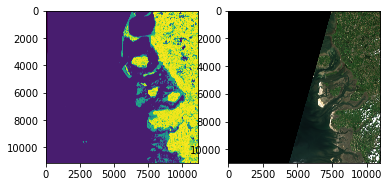

In [32]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(lc_arr[0])
ax[1].imshow(np.moveaxis(rgb_arr, 0, -1))

### finally, reproject to rgb projection

In [24]:
lc_align = align(lc, rgb, lc_arr, rgb_arr)

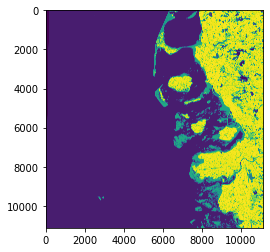

In [25]:
plt.imshow(lc_arr[0])

In [26]:
# they all should now have the same shape

scl_align[0].shape == rgb_arr[0].shape == lc_align[0].shape

True

In [27]:
lc.close()